# The Traveling Salesman 

"Given a list of cities and the distances between each pair of the cities, find the shortest
possible path that goes through all the cities, and returns to the starting city."


![](./../img/2024-03-31-14-23-19.png)

### Resources

- [Youtube: What is the Traveling Salesman Problem? - AlphaOpt](https://www.youtube.com/watch?v=1pmBjIZ20pE&ab_channel=AlphaOpt)


## Activity Building the Traveling Salesman Problem

### Problem

```{note}

1. Create a class named `TravelingSalesmanProblem` that will have the following methods:
    - `def __init__(self, name):` Creates Instances
    - `def __len__(self):`  Returns the length of the number of cities.
    - `def __createData(self):` Creates the data from the file.
    - `def getTotalDistance(self, indices):` Returns the total distance of the path.
    - `def plotData(self, indices):` Plots the data.


```

Test it with the following:

```python
tsp = TravelingSalesmanProblem("bayg29")

# generate a random solution and evaluate it:
#randomSolution = random.sample(range(len(tsp)), len(tsp))

# see http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.opt.tour
optimalSolution = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]

print("Problem name: " + tsp.name)
print("Optimal solution = ", optimalSolution)
print("Optimal distance = ", tsp.getTotalDistance(optimalSolution))

# plot the solution:
plot = tsp.plotData(optimalSolution)
plot.show()
```

It should print the following:

```
Problem name: bayg29
Optimal solution =  [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
Optimal distance =  9074.147
```

![](./../img/2024-04-23-15-35-43.png)


### Solution


In [79]:
import csv
import pickle
import os
import codecs

import numpy as np

from urllib.request import urlopen

import matplotlib.pyplot as plt

In [80]:

class TravelingSalesmanProblem:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from an online file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.

    :param name: The name of the corresponding TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """

    def __init__(self, name):
        """
        Creates an instance of a TSP

        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the serialized data, and if not available - calls __create_data() to prepare it
        """

        # attempt to read serialized data:
        try:
            self.locations = pickle.load(open(os.path.join("tsp-data", self.name + "-loc.pickle"), "rb"))
            self.distances = pickle.load(open(os.path.join("tsp-data", self.name + "-dist.pickle"), "rb"))
        except (OSError, IOError):
            pass

        # serailized data not found - create the data from scratch:
        if not self.locations or not self.distances:
            self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file from the Internet, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        It then serializes the city locations and the calculated distances to disk using the pickle utility.
        """
        self.locations = []

        # print("http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + self.name + ".tsp")
        
        # Use the following instead: https://raw.githubusercontent.com/mastqe/tsplib/master/a280.tsp
        URL = "https://raw.githubusercontent.com/mastqe/tsplib/master/"
        print(URL + self.name + ".tsp")
        # open whitespace-delimited file from url and read lines from it:
        with urlopen(URL + self.name + ".tsp") as f:
            reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))

            # serialize locations and distances:
            if not os.path.exists("tsp-data"):
                os.makedirs("tsp-data")
            pickle.dump(self.locations, open(os.path.join("tsp-data", self.name + "-loc.pickle"), "wb"))
            pickle.dump(self.distances, open(os.path.join("tsp-data", self.name + "-dist.pickle"), "wb"))

    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices):
        """plots the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.scatter(*zip(*self.locations), marker='.', color='red')

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')

        return plt

Problem name: bayg29
Optimal solution =  [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]
Optimal distance =  9074.147


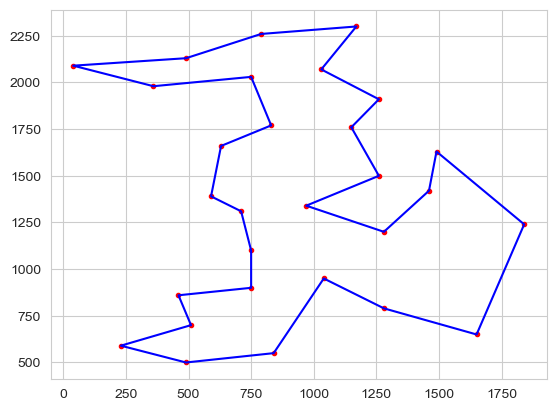

In [81]:
tsp = TravelingSalesmanProblem("bayg29")

# generate a random solution and evaluate it:
#randomSolution = random.sample(range(len(tsp)), len(tsp))

# see http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.opt.tour
optimalSolution = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]

print("Problem name: " + tsp.name)
print("Optimal solution = ", optimalSolution)
print("Optimal distance = ", tsp.getTotalDistance(optimalSolution))

# plot the solution:
plot = tsp.plotData(optimalSolution)
plot.show()

## Solving TSP Using DEAP Framework


### Problem

Now you will use the Deap framework to evaluate and find the best solutions.
Use the following parameters:

- POPULATION SIZE = 300
- NUMBER OF GENERATIONS = 100
- HALL_OF_FAME_SIZE = 1
- Probability of crossover = 0.9
- Probability of mutation = 0.1
- Which is the idea fitness strategy?
- Create a class of individual, whichuses the min fitness class as a fitness calculation.
- Register an operator named `randomOrder` that generates a random permutation of the cities.
- Register an operator named `individualCreator` which responsability is to use individual and randomOrder tool.
- Create a populationCreator that generates the list of individuals


- Make the evaluation as the total distance of the path.
- Use tournament selection with a tournament size of 3.
- Use [cxOrdered](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered) crossover and [mutationShuffleIndexes](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes) mutation.
- 


```{note}

**deap.tools.mutShuffleIndexes(individual, indpb)[source]**

Shuffle the attributes of the input individual and return the mutant. The individual is expected to be a sequence. The indpb argument is the probability of each attribute to be moved. Usually this mutation is applied on vector of indices.

**deap.tools.cxOrdered(ind1, ind2)[source]**

Executes an ordered crossover (OX) on the input individuals. The two individuals are modified in place. This crossover expects sequence individuals of indices, the result for any other type of individuals is unpredictable.


More Operators:

![](./../img/2024-04-23-16-12-03.png)

```

### Solution



In [82]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random
import array

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [83]:
# set the random seed for repeatable results
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the desired traveling salesman problem instace:
TSP_NAME = "bayg29"  # name of problem
tsp = TravelingSalesmanProblem(TSP_NAME)

# Genetic Algorithm constants:
POPULATION_SIZE = 300
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 1
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual

toolbox = base.Toolbox()

In [84]:

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(tsp)), len(tsp))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [85]:
# Calculating The Distance as the TSP Distance.


# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return tsp.getTotalDistance(individual),  # return a tuple



toolbox.register("evaluate", tpsDistance)

# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))


In [86]:

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [87]:


# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
# perform the Genetic Algorithm flow with hof feature added:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])


gen	nevals	min    	avg  
0  	300   	21103.3	26457
1  	279   	19562.4	25128.9
2  	275   	19456.5	24267.3
3  	279   	19760.9	23592  
4  	278   	19406.4	22963.5
5  	276   	19105.2	22480.7
6  	281   	17802.4	22129.9
7  	279   	18160.2	21581.5
8  	274   	17691.3	21253.6
9  	277   	16011.9	20877.8
10 	268   	16011.9	20597.9
11 	279   	15878.8	20413.2
12 	269   	14589.1	20188.2
13 	272   	14589.1	19987.8
14 	281   	15182.9	19910.4
15 	276   	15836.2	19437  
16 	276   	15687.4	19117.2
17 	282   	15426.5	19039.4
18 	282   	14905.2	18696.7
19 	269   	15020.4	18614.9
20 	275   	13346.3	18424  
21 	276   	14711.4	18330.1
22 	275   	13139.1	18312  
23 	274   	13139.1	18005  
24 	278   	13002.5	17725.6
25 	262   	12203.5	17543.2
26 	274   	13157.3	17285.2
27 	260   	12918.6	16946.3
28 	271   	12918.6	16646  
29 	262   	12918.6	16441  
30 	279   	12652.9	16194.2
31 	265   	12652.9	15910.6
32 	278   	12565.6	15942.4
33 	278   	12520.5	15682  
34 	283   	12436.1	15569.5
35 	272   	12214  	15441.9
36 	2

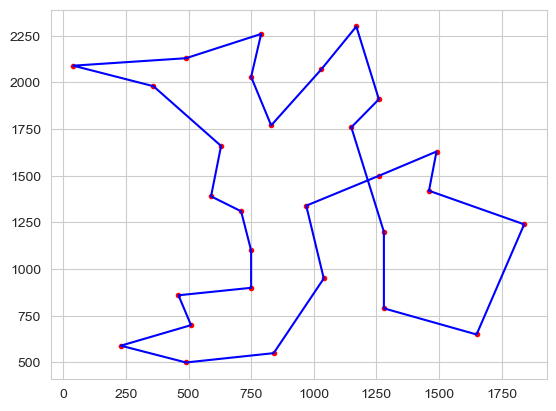

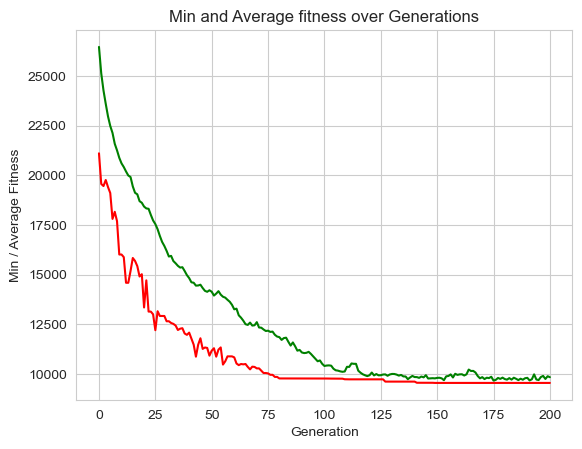

In [88]:


# plot best solution:
plt.figure(1)
tsp.plotData(best)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()

## TSP Modifying Tour Size: 3

- Experimenting with the Tournament Size reveals that: When the size is increasing the size of the torunament, is not able to retain the best solutions.. 



In [89]:
# Calculating The Distance as the TSP Distance.


# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return tsp.getTotalDistance(individual),  # return a tuple


toolbox.register("evaluate", tpsDistance)


# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)



# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])


gen	nevals	min    	avg    
0  	300   	21103.5	26399.8
1  	274   	21361.6	25481.4
2  	258   	19153.7	24928.2
3  	285   	18299.3	24318.2
4  	275   	19199.8	23753.1
5  	271   	18344.1	23313.5
6  	270   	18344.1	23081.9
7  	264   	18078.7	22838.6
8  	273   	17945.4	22705.6
9  	276   	18042.5	22653.7
10 	263   	17340.4	22467.2
11 	268   	17549.7	22291.7
12 	272   	17144.4	22138.2
13 	274   	17379.9	21704.1
14 	269   	17143.3	21659.2
15 	261   	17288.3	21517.3
16 	273   	16224.5	21419.9
17 	277   	16676.9	21367.1
18 	263   	15293  	21390.3
19 	272   	16688.3	21436.5
20 	272   	16388.9	21475.2
21 	270   	16388.9	21326.1
22 	278   	16014.6	21420.9
23 	273   	16779.1	21255.7
24 	278   	16615  	21044  
25 	254   	16738.1	20971.9
26 	274   	17463  	21139.5
27 	274   	17331.4	21043.8
28 	272   	16859.7	20956.5
29 	271   	16402  	20855  
30 	271   	16206.3	20919.5
31 	271   	16492.5	20749.2
32 	268   	16853.3	20707.1
33 	264   	16667.7	20748.3
34 	288   	16083.8	20855.3
35 	277   	16157.7	20896.1
3

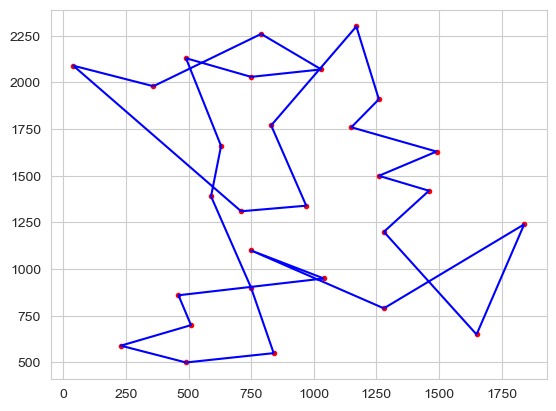

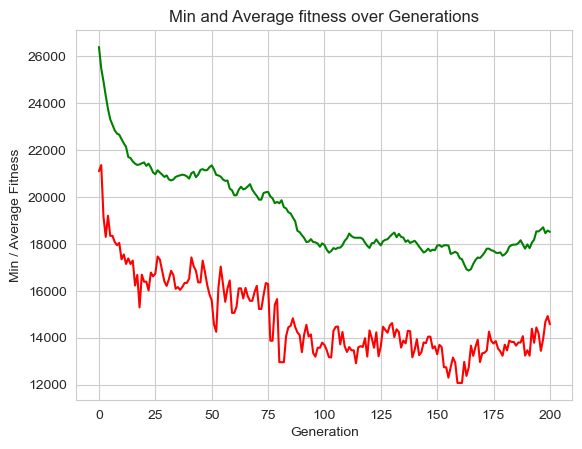

In [90]:


# plot best solution:
plt.figure(1)
tsp.plotData(best)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()

gen	nevals	min    	avg    
0  	300   	21219.9	26467.8
1  	276   	20638  	25521.8
2  	282   	20272.5	24884.4
3  	260   	18344.9	24197.1
4  	278   	18344.9	23918.4
5  	278   	17194.8	23487.6
6  	280   	17194.8	23202.3
7  	282   	17194.8	23106  
8  	275   	17194.8	22890.5
9  	278   	16695.1	22527.2
10 	273   	16695.1	22323.1
11 	279   	16695.1	22103  
12 	275   	16695.1	21905.8
13 	262   	16695.1	21578.5
14 	270   	16695.1	21511.8
15 	271   	16695.1	21421.8
16 	267   	16695.1	21416.1
17 	269   	16448.3	21469.7
18 	271   	16443.9	21180.3
19 	278   	16443.9	21154.2
20 	282   	16443.9	21224.8
21 	273   	16147.2	21298.1
22 	275   	16147.2	21319.3
23 	270   	16147.2	21238.5
24 	277   	14959.4	21254.6
25 	269   	14959.4	21262.3
26 	272   	14959.4	21114.6
27 	260   	14959.4	21199.2
28 	280   	14959.4	21174  
29 	270   	14959.4	21024.7
30 	271   	14959.4	20909.9
31 	267   	14959.4	20744  
32 	270   	14505.1	20586.8
33 	276   	14505.1	20572.7
34 	268   	14505.1	20585.1
35 	277   	14505.1	20593.3
3

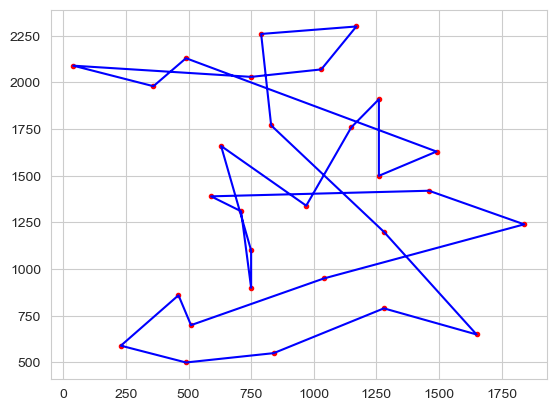

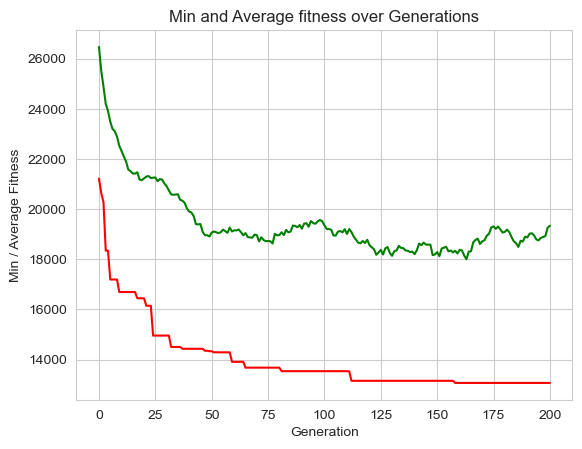

In [91]:
### Attempt using Elitism

import elitism

# Calculating The Distance as the TSP Distance.


# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return tsp.getTotalDistance(individual),  # return a tuple


toolbox.register("evaluate", tpsDistance)


# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)



# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
# population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
#                                             ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)


# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])



# plot best solution:
plt.figure(1)
tsp.plotData(best)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()


gen	nevals	min    	avg  
0  	300   	21103.3	26457
1  	252   	19726.4	25210.9
2  	249   	18977.1	24364.3
3  	257   	17868.2	23514.7
4  	237   	17585.3	22929.8
5  	247   	17585.3	22350.6
6  	247   	17585.3	21831.4
7  	249   	17012.3	21442.6
8  	238   	17012.3	20999.7
9  	249   	16856.3	20513.2
10 	249   	16766.4	20235.4
11 	249   	16165.7	19852.8
12 	244   	14934  	19588.4
13 	242   	14934  	19454.3
14 	252   	14934  	19412.6
15 	245   	14757.5	19286.6
16 	242   	14757.5	19057.2
17 	253   	14757.5	18846.9
18 	246   	14757.5	18782.7
19 	240   	14607  	18293.7
20 	249   	14607  	17740.2
21 	248   	14227.7	17786.1
22 	238   	14227.7	17546.7
23 	242   	12893.9	17310.7
24 	245   	12893.9	16959.3
25 	241   	12893.9	16699.8
26 	242   	12766.2	16481.4
27 	246   	12766.2	16321.5
28 	246   	12662.4	16263.8
29 	236   	12662.4	15799.7
30 	248   	12610.1	15691.9
31 	245   	12610.1	15636.5
32 	247   	12410.6	15465  
33 	253   	12199.6	15328.7
34 	242   	12199.6	15059.9
35 	237   	11848.8	15000.8
36 	2

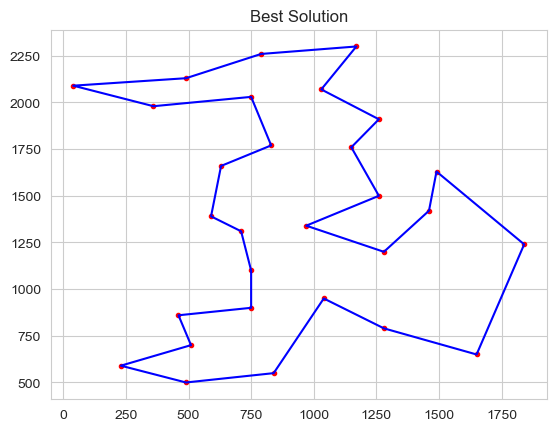

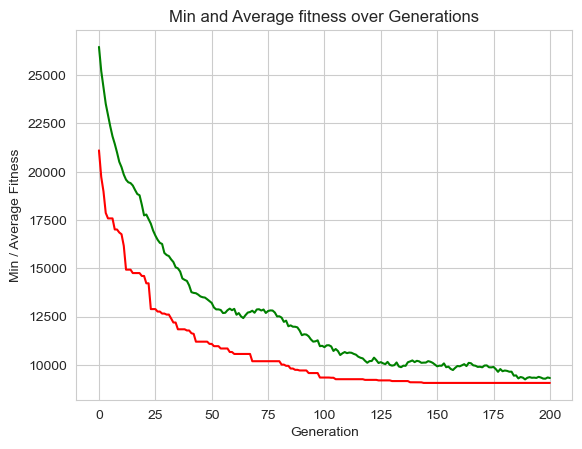

In [92]:
from deap import base
from deap import creator
from deap import tools

import random
import array

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tsp
import elitism

# set the random seed for repeatable results
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the desired traveling salesman problem instace:
TSP_NAME = "bayg29"  # name of problem
tsp = tsp.TravelingSalesmanProblem(TSP_NAME)

# Genetic Algorithm constants:
POPULATION_SIZE = 300
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(tsp)), len(tsp))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return tsp.getTotalDistance(individual),  # return a tuple


toolbox.register("evaluate", tpsDistance)


# Genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))



# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# plot best solution:
plt.figure(1)
tsp.plotData(best, label='Best Solution')

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()

